In [67]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#Kmeans
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


#decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_text
from sklearn.tree import export_graphviz
import pydot
from sklearn.tree import plot_tree

#ANN
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model


# Make data frame

In [18]:
# Read in the CSV file with two sheets
xls = pd.ExcelFile('Test Case.xlsx')
df_demand = pd.read_excel(xls, 'Demand')
df_dates = pd.read_excel(xls, 'Dates')

xls2 = pd.ExcelFile('instant.xlsx')
df_instant = pd.read_excel(xls2)


In [19]:
# Convert date strings to datetime objects and after to numirical format with the purpose of 
df_demand['Date'] = pd.to_datetime(df_demand['Date'])
df_demand['Date'] = df_demand['Date'].apply(lambda x: x.toordinal())
df_dates['Date En'] = pd.to_datetime(df_dates['Date En'])
df_dates['Date En'] = df_dates['Date En'].apply(lambda x: x.toordinal())


In [20]:
# Merge the two dataframes on the Date column
df = pd.merge(df_demand, df_dates[['Date En', 'IsWeekend']], left_on='Date', right_on='Date En')

In [21]:
# Convert boolean IsWeekend column to 1's and 0's
df['IsWeekend'] = df['IsWeekend'].astype(int)

In [22]:
df_instant['Date'] = pd.to_datetime(df_instant['Date'])
df_instant['Date'] = df_instant['Date'].apply(lambda x: x.toordinal())
df = pd.merge(df_instant, df[['Date En', 'IsWeekend','Demand_Total Areas']], left_on='Date', right_on='Date En')
df.head()

,instant,Date,Date En,IsWeekend,Demand_Total Areas
0,77,738510,738510,1,11069.0
1,72,738509,738509,0,11373.0
2,97,738508,738508,0,13153.0
3,95,738507,738507,0,12989.0
4,67,738506,738506,0,11509.0


In [23]:
df_orders = pd.read_excel(xls, 'Orders')
df_orders['Date'] = pd.to_datetime(df_orders['Date'])
df_orders['Date'] = df_orders['Date'].apply(lambda x: x.toordinal())

### Make scaled data 

In [24]:
# Create a StandardScaler object
scaler = StandardScaler()

# Define the columns to be scaled
columns_to_scale = ['Rate_Count', 'Rate_Score']

# Fit and transform the selected columns using StandardScaler
scaled_data = scaler.fit_transform(df_orders[columns_to_scale])

# Create new column names for the scaled data
new_column_names = [column + '_scaled' for column in columns_to_scale]

# Create a new dataframe with the scaled data
scaled_df = pd.DataFrame(scaled_data, columns=new_column_names)

# Concatenate the original dataframe with the scaled dataframe
df_orders = pd.concat([df_orders, scaled_df], axis=1)
df_orders.head()

,Date,Order-ID,Accommodation_Code,Areas_Id,Rate_Count,Rate_Score,IsInstant,IsFinalizedOrder,IsHostAccepted,IsGuestPaid,Rate_Count_scaled,Rate_Score_scaled
0,738510,461332,277537,912,84,4.0,False,True,True,True,0.697831,0.029888
1,738510,461326,256370,912,141,3.7,False,False,True,False,1.905828,-0.233393
2,738510,461323,253572,139,63,4.4,True,False,True,False,0.252780,0.380930
3,738510,461319,259745,912,0,0.0,False,False,False,False,-1.082375,-3.480528
4,738510,461315,311907,912,0,0.0,True,True,True,True,-1.082375,-3.480528


In [25]:
orders_per_day = df_orders.groupby('Date')['Order-ID'].count()
df = pd.merge(df, orders_per_day, on='Date')

In [26]:
df.head()

,instant,Date,Date En,IsWeekend,Demand_Total Areas,Order-ID
0,77,738510,738510,1,11069.0,217
1,72,738509,738509,0,11373.0,222
2,97,738508,738508,0,13153.0,238
3,95,738507,738507,0,12989.0,230
4,67,738506,738506,0,11509.0,243


# Estimate Demand in next two weeks

## Model1

In [41]:
# Split data into training and testing sets (keep last 14 days for testing)
train = df[-46:]
test = df[:-46]
test.dtypes

instant                 int64
Date                    int64
Date En                 int64
IsWeekend               int32
Demand_Total Areas    float64
Order-ID                int64
dtype: object

In [42]:
# Fit linear regression model
model = LinearRegression()
model.fit(train[['Date', 'IsWeekend']], train['Demand_Total Areas'])
coef = model.coef_
intercept = model.intercept_
print('Regression Formula: Demand_Total Areas = {:.2f}*Date + {:.2f}*IsWeekend + {:.2f}'.format(coef[0], coef[1], intercept))


Regression Formula: Demand_Total Areas = -34.13*Date + 409.48*IsWeekend + 25217924.79


### evaluating model1


C:\Users\MMEC82~1.NEZ\AppData\Local\Temp/ipykernel_14040/3112190308.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Demand_Pred'] = model.predict(train[['Date', 'IsWeekend']])


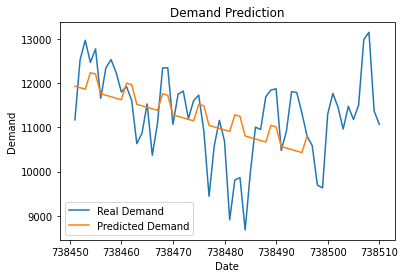

In [43]:
# Predict demand using the test data
train['Demand_Pred'] = model.predict(train[['Date', 'IsWeekend']])

# Plot real and predicted demand
plt.plot(df['Date'], df['Demand_Total Areas'], label='Real Demand')
plt.plot(train['Date'], train['Demand_Pred'], label='Predicted Demand')

# Set plot title and axis labels
plt.title('Demand Prediction')
plt.xlabel('Date')
plt.ylabel('Demand')

# Add legend
plt.legend()

# Show plot
plt.show()

In [44]:
y_true = test['Demand_Total Areas']
y_pred = model.predict(test[['Date', 'IsWeekend']])
r2 = r2_score(y_true, y_pred)
print("R-squared on test data:", r2)

R-squared on test data: -1.5014874938336171


##### As we can see , this model is not proper(R-2 is negative which mean that model slop is not compare in right direction ) . so we try to use Log which make our model more linear .

## Mdel2

In [45]:
df['log_Demand'] = df['Demand_Total Areas'].apply(lambda x: np.log10(x))
df.head()

,instant,Date,Date En,IsWeekend,Demand_Total Areas,Order-ID,log_Demand
0,77,738510,738510,1,11069.0,217,4.044108
1,72,738509,738509,0,11373.0,222,4.055875
2,97,738508,738508,0,13153.0,238,4.119025
3,95,738507,738507,0,12989.0,230,4.113576
4,67,738506,738506,0,11509.0,243,4.061038


In [46]:
train_2 = df[-46:]
test_2 = df[:-46]
test.dtypes

instant                 int64
Date                    int64
Date En                 int64
IsWeekend               int32
Demand_Total Areas    float64
Order-ID                int64
dtype: object

In [47]:
# Fit linear regression model
model2 = LinearRegression()
model2.fit(train_2[['Date', 'IsWeekend']], train_2['log_Demand'])
coef = model2.coef_
intercept = model2.intercept_
print('Regression Formula: Demand_Total Areas = {:.2f}*Date + {:.2f}*IsWeekend + {:.2f}'.format(coef[0], coef[1], intercept))


Regression Formula: Demand_Total Areas = -0.00*Date + 0.02*IsWeekend + 977.80


### Evaluating Model2

C:\Users\MMEC82~1.NEZ\AppData\Local\Temp/ipykernel_14040/3190788208.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_2['log_Demand_Pred'] = model2.predict(train_2[['Date', 'IsWeekend']])


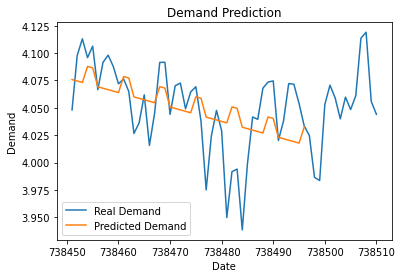

In [48]:
# Predict demand using the test data
train_2['log_Demand_Pred'] = model2.predict(train_2[['Date', 'IsWeekend']])

# Plot real and predicted demand
plt.plot(df['Date'], df['log_Demand'], label='Real Demand')
plt.plot(train_2['Date'], train_2['log_Demand_Pred'], label='Predicted Demand')

# Set plot title and axis labels
plt.title('Demand Prediction')
plt.xlabel('Date')
plt.ylabel('Demand')

# Add legend
plt.legend()

# Show plot
plt.show()

In [49]:
y_true = test['log_Demand']
y_pred2 = model.predict(test_2[['Date', 'IsWeekend']])
r2 = r2_score(y_true, y_pred2)
print("R-squared on test data:", r2)

KeyError: 'log_Demand'

##### As we can see , this model is not proper(R-2 is negative which mean that model slop is not compare in right direction ) . so we try to use Log which make our model more linear .

## Model3 

#### in this model we will try to fit quadratic polynomial

In [50]:
# Split data into training and testing sets (keep last 14 days for testing)
train = df[-46:]
test = df[:-46]
test

,instant,Date,Date En,IsWeekend,Demand_Total Areas,Order-ID,log_Demand
0,77,738510,738510,1,11069.0,217,4.044108
1,72,738509,738509,0,11373.0,222,4.055875
2,97,738508,738508,0,13153.0,238,4.119025
3,95,738507,738507,0,12989.0,230,4.113576
4,67,738506,738506,0,11509.0,243,4.061038
5,56,738505,738505,0,11179.0,213,4.048403
6,81,738504,738504,1,11476.0,231,4.059791
7,94,738503,738503,1,10963.0,257,4.039929
8,85,738502,738502,0,11458.0,251,4.059109
9,83,738501,738501,0,11768.0,274,4.070703


In [51]:
X = train[['Date', 'IsWeekend']]
X['Date_squared'] = X['Date'] ** 2
y = train['Demand_Total Areas']
X.head()


C:\Users\MMEC82~1.NEZ\AppData\Local\Temp/ipykernel_14040/3668218336.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Date_squared'] = X['Date'] ** 2


,Date,IsWeekend,Date_squared
14,738496,1,545376342016
15,738495,0,545374865025
16,738494,0,545373388036
17,738493,0,545371911049
18,738492,0,545370434064


In [52]:
# Create polynomial features for the independent variables (up to degree 2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

In [53]:
# Fit the quadratic regression model with dummy variable
model3 = LinearRegression()
model3.fit(X_poly, y)

LinearRegression()

### evaluaitng

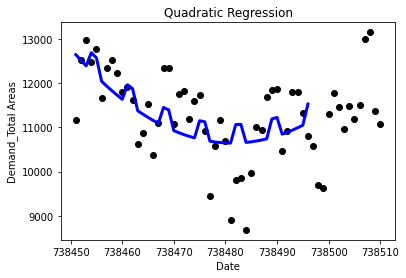

In [54]:
# Predict demand using the test data

y_pred = model3.predict(X_poly)

plt.scatter(df['Date'], df['Demand_Total Areas'], color='black')
plt.plot(X['Date'], y_pred, color='blue', linewidth=3)
plt.xlabel('Date')
plt.ylabel('Demand_Total Areas')
plt.title('Quadratic Regression')
plt.show()

In [55]:
y_true = test['Demand_Total Areas']

X = test[['Date', 'IsWeekend']]
X['Date_squared'] = X['Date'] ** 2
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly_test = poly.fit_transform(X)
y_pred = model3.predict(X_poly_test)

r2 = r2_score(y_true, y_pred)
print("R-squared on test data:", r2)

R-squared on test data: -0.15158497788408498


C:\Users\MMEC82~1.NEZ\AppData\Local\Temp/ipykernel_14040/1774180298.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Date_squared'] = X['Date'] ** 2


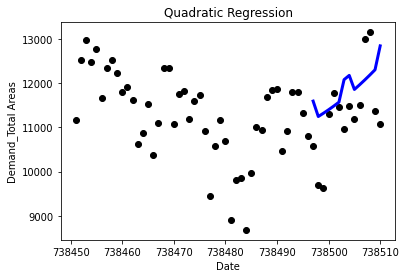

In [56]:
plt.scatter(df['Date'], df['Demand_Total Areas'], color='black')
plt.plot(X['Date'], y_pred, color='blue', linewidth=3)
plt.xlabel('Date')
plt.ylabel('Demand_Total Areas')
plt.title('Quadratic Regression')
plt.show()

#### this model is better , but it is not proper for predicting 2 week (as it increasing dramaticly)

## Model4

in this model we will take second half of data into account . the reason is that dwon trend changed into uptrend form middle . 

In [57]:
#this model dose not have train and test data set. becuse amount of data was not proper for spliting data to two part
train = df[0:31]
test = df[0:31]

In [58]:
# Fit linear regression model
model4 = LinearRegression()
model4.fit(train[['Date', 'IsWeekend']], train['Demand_Total Areas'])
coef = model4.coef_
intercept = model4.intercept_
print('Regression Formula: Demand_Total Areas = {:.2f}*Date + {:.2f}*IsWeekend + {:.2f}'.format(coef[0], coef[1], intercept))

Regression Formula: Demand_Total Areas = 61.73*Date + -81.54*IsWeekend + -45575410.63


### evaluation

C:\Users\MMEC82~1.NEZ\AppData\Local\Temp/ipykernel_14040/3959234985.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Demand_Pred'] = model4.predict(train[['Date', 'IsWeekend']])


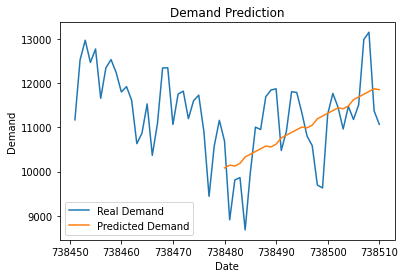

In [59]:
# Predict demand using the test data
train['Demand_Pred'] = model4.predict(train[['Date', 'IsWeekend']])

# Plot real and predicted demand
plt.plot(df['Date'], df['Demand_Total Areas'], label='Real Demand')
plt.plot(train['Date'], train['Demand_Pred'], label='Predicted Demand')

# Set plot title and axis labels
plt.title('Demand Prediction')
plt.xlabel('Date')
plt.ylabel('Demand')

# Add legend
plt.legend()

# Show plot
plt.show()

In [60]:
y_true = test['Demand_Total Areas']
y_pred = model4.predict(test[['Date', 'IsWeekend']])
r2 = r2_score(y_true, y_pred)
print("R-squared on test data:", r2)

R-squared on test data: 0.3048858652372607


it is best prediction of this model 


## Model5

Considering that we just take last 35 data into account . Becuse first half data and second one has different trend.

In [61]:
df_copy = df.copy()
df_copy = df_copy[0:35]
X = df_copy[["Date","IsWeekend"]]
y = df_copy["Demand_Total Areas"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26)

In [62]:
# Fit linear regression model
model = LinearRegression()
model.fit(X_train, y_train)
coef = model.coef_
intercept = model.intercept_
print('Regression Formula: Demand_Total Areas = {:.2f}*Date + {:.2f}*IsWeekend + {:.2f}'.format(coef[0], coef[1], intercept))

Regression Formula: Demand_Total Areas = 44.18*Date + 104.87*IsWeekend + -32618803.89


In [63]:
y_pred = model.predict(X_test)
# Calculate the R-squared score on the test set
r2 = r2_score(y_test, y_pred)
print("R-squared on test data:", r2)
y_pred , y_test

R-squared on test data: 0.49077648314772304


(array([11296.07647475, 10561.45041228, 10235.65489225, 10898.41838131,
        10986.78684652, 11489.31929696, 10589.12875308]),
 9     11768.0
 28     9811.0
 33     9441.0
 18    10916.0
 16    11790.0
 7     10963.0
 25     9973.0
 Name: Demand_Total Areas, dtype: float64)

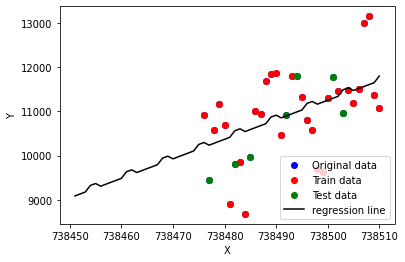

In [64]:
# Plot scatter plot
plt.scatter(df_copy['Date'], df_copy['Demand_Total Areas'], color='blue', label='Original data')
plt.scatter(X_train['Date'], y_train, color='red', label='Train data')
plt.scatter(X_test['Date'], y_test, color='green', label='Test data')
plt.plot(df['Date'], model.predict(df[['Date', 'IsWeekend']]), color='k', label='regression line')
plt.legend(loc='lower right')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Demand Prediction based on Model5

In [65]:
# Create date range from 738511 to 738524
date_range = pd.date_range(start='12/22/2022', periods=14).to_series().apply(lambda x: x.toordinal())

# Create dataframe with Date column
df_predicted = pd.DataFrame({'Date': date_range})

# Manually add Isweekend column
df_predicted['IsWeekend'] = [1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1]

print(df_predicted)

              Date  IsWeekend
2022-12-22  738511          1
2022-12-23  738512          0
2022-12-24  738513          0
2022-12-25  738514          0
2022-12-26  738515          0
2022-12-27  738516          0
2022-12-28  738517          1
2022-12-29  738518          1
2022-12-30  738519          0
2022-12-31  738520          0
2023-01-01  738521          0
2023-01-02  738522          0
2023-01-03  738523          0
2023-01-04  738524          1


In [66]:
# Generate demand predictions for next 14 days using Model 4
df_predicted['Demand_Predicted'] = model4.predict(df_predicted[['Date', 'IsWeekend']])
df_predicted


,Date,IsWeekend,Demand_Predicted
2022-12-22,738511,1,11915.630885
2022-12-23,738512,0,12058.902157
2022-12-24,738513,0,12120.630970
2022-12-25,738514,0,12182.359784
2022-12-26,738515,0,12244.088597
2022-12-27,738516,0,12305.817411
2022-12-28,738517,1,12286.003766
2022-12-29,738518,1,12347.732579
2022-12-30,738519,0,12491.003851
2022-12-31,738520,0,12552.732665


# Estimate Instant in next two weeks

## Model1

In [67]:
train = df[-40:]
test = df[:-40]

In [68]:
# Fit linear regression model
model = LinearRegression()
model.fit(train[['Date', 'IsWeekend']], train['instant'])
coef = model.coef_
intercept = model.intercept_
print('Regression Formula: Demand_Total Areas = {:.2f}*Date + {:.2f}*IsWeekend + {:.2f}'.format(coef[0], coef[1], intercept))


Regression Formula: Demand_Total Areas = -0.38*Date + -12.22*IsWeekend + 279609.05


C:\Users\MMEC82~1.NEZ\AppData\Local\Temp/ipykernel_14040/1348638988.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['instant_Pred'] = model.predict(train[['Date', 'IsWeekend']])


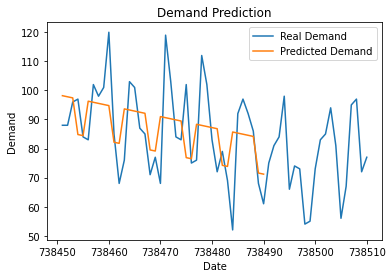

In [69]:
# Predict demand using the test data
train['instant_Pred'] = model.predict(train[['Date', 'IsWeekend']])

# Plot real and predicted demand
plt.plot(df['Date'], df['instant'], label='Real Demand')
plt.plot(train['Date'], train['instant_Pred'], label='Predicted Demand')

# Set plot title and axis labels
plt.title('Demand Prediction')
plt.xlabel('Date')
plt.ylabel('Demand')

# Add legend
plt.legend()

# Show plot
plt.show()

In [70]:
y_true = test['instant']
y_pred = model.predict(test[['Date', 'IsWeekend']])
r2 = r2_score(y_true, y_pred)
print("R-squared on test data:", r2)

R-squared on test data: -0.3456077151479948


In [71]:
df.head()

,instant,Date,Date En,IsWeekend,Demand_Total Areas,Order-ID,log_Demand
0,77,738510,738510,1,11069.0,217,4.044108
1,72,738509,738509,0,11373.0,222,4.055875
2,97,738508,738508,0,13153.0,238,4.119025
3,95,738507,738507,0,12989.0,230,4.113576
4,67,738506,738506,0,11509.0,243,4.061038


## Model2

in this model we will not consider 'isweekend'

In [72]:
train = df[:30]
test = df[:]
train

,instant,Date,Date En,IsWeekend,Demand_Total Areas,Order-ID,log_Demand
0,77,738510,738510,1,11069.0,217,4.044108
1,72,738509,738509,0,11373.0,222,4.055875
2,97,738508,738508,0,13153.0,238,4.119025
3,95,738507,738507,0,12989.0,230,4.113576
4,67,738506,738506,0,11509.0,243,4.061038
5,56,738505,738505,0,11179.0,213,4.048403
6,81,738504,738504,1,11476.0,231,4.059791
7,94,738503,738503,1,10963.0,257,4.039929
8,85,738502,738502,0,11458.0,251,4.059109
9,83,738501,738501,0,11768.0,274,4.070703


In [73]:
# Fit linear regression model
model = LinearRegression()
model.fit(train[['Date']], train['instant'])
coef = model.coef_
intercept = model.intercept_
print('Regression Formula: Demand_Total Areas = {:.2f}*Date + {:.2f}'.format(coef[0], intercept))


Regression Formula: Demand_Total Areas = 0.07*Date + -52496.72


C:\Users\MMEC82~1.NEZ\AppData\Local\Temp/ipykernel_14040/2499686664.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['instant_Pred'] = model.predict(train[['Date']])


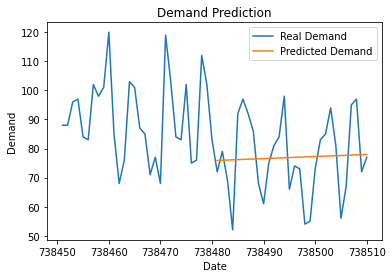

In [74]:
# Predict demand using the test data
train['instant_Pred'] = model.predict(train[['Date']])

# Plot real and predicted demand
plt.plot(df['Date'], df['instant'], label='Real Demand')
plt.plot(train['Date'], train['instant_Pred'], label='Predicted Demand')

# Set plot title and axis labels
plt.title('Demand Prediction')
plt.xlabel('Date')
plt.ylabel('Demand')

# Add legend
plt.legend()

# Show plot
plt.show()

In [75]:
y_true = test['instant']
y_pred = model.predict(test[['Date']])
r2 = r2_score(y_true, y_pred)
print("R-squared on test data:", r2)

R-squared on test data: -0.3372879526509258


## Model 3

In this model we will use another method to split data into tetst and train

In [76]:
df_copy = df.copy()
X = df_copy[["Date"]]
y = df_copy["instant"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [77]:
# Fit linear regression model
model = LinearRegression()
model.fit(X_train, y_train)
coef = model.coef_
intercept = model.intercept_
print('Regression Formula: Demand_Total Areas = {:.2f}*Date + {:.2f}'.format(coef[0], intercept))

Regression Formula: Demand_Total Areas = -0.25*Date + 183243.94


In [78]:
y_pred = model.predict(X_test)
# Calculate the R-squared score on the test set
r2 = r2_score(y_test, y_pred)
print("R-squared on test data:", r2)

R-squared on test data: 0.2586809238380795


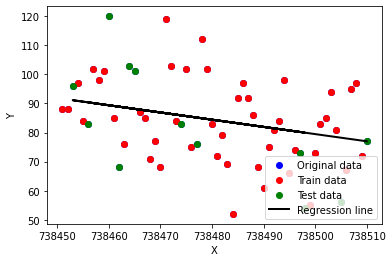

In [79]:
# Plot scatter plot
plt.scatter(df_copy['Date'], df['instant'], color='blue', label='Original data')
plt.scatter(X_train, y_train, color='red', label='Train data')
plt.scatter(X_test, y_test, color='green', label='Test data')
plt.plot(X_test, y_pred, color='black', linewidth=2, label='Regression line')
plt.legend(loc='lower right')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Model4

In [80]:
df_copy = df.copy()
X = df_copy[["Date","IsWeekend"]]
y = df_copy["instant"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
# Fit linear regression model
model = LinearRegression()
model.fit(X_train, y_train)
coef = model.coef_
intercept = model.intercept_
print('Regression Formula: Demand_Total Areas = {:.2f}*Date + {:.2f}*IsWeekend + {:.2f}'.format(coef[0], coef[1], intercept))


Regression Formula: Demand_Total Areas = -0.27*Date + -6.98*IsWeekend + 196947.80


In [82]:
y_pred = model.predict(X_test)
# Calculate the R-squared score on the test set
r2 = r2_score(y_test, y_pred)
print("R-squared on test data:", r2)
y_pred

R-squared on test data: 0.30531743139122225


array([71.5028058 , 79.81772071, 88.08158803, 90.48077532, 74.96829854,
       92.87996261, 87.28185894, 84.29847133, 81.68375527, 93.6796917 ,
       90.74735169, 91.81365715])

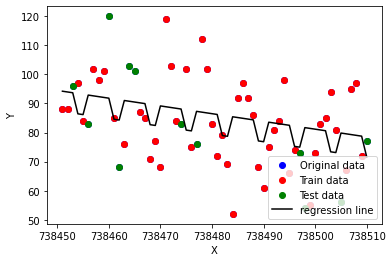

In [83]:
# Plot scatter plot
plt.scatter(df_copy['Date'], df['instant'], color='blue', label='Original data')
plt.scatter(X_train['Date'], y_train, color='red', label='Train data')
plt.scatter(X_test['Date'], y_test, color='green', label='Test data')
plt.plot(df['Date'], model.predict(df[['Date', 'IsWeekend']]), color='k', label='regression line')
plt.legend(loc='lower right')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Predicting Based on Final model 

In [84]:
# Create date range from 738511 to 738524
date_range = pd.date_range(start='12/22/2022', periods=14).to_series().apply(lambda x: x.toordinal())

# Create dataframe with Date column
df_predicted = pd.DataFrame({'Date': date_range})

# Manually add Isweekend column
df_predicted['IsWeekend'] = [1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1]

print(df_predicted)

              Date  IsWeekend
2022-12-22  738511          1
2022-12-23  738512          0
2022-12-24  738513          0
2022-12-25  738514          0
2022-12-26  738515          0
2022-12-27  738516          0
2022-12-28  738517          1
2022-12-29  738518          1
2022-12-30  738519          0
2022-12-31  738520          0
2023-01-01  738521          0
2023-01-02  738522          0
2023-01-03  738523          0
2023-01-04  738524          1


In [85]:
# Generate demand predictions for next 14 days using Model 4
df_predicted['Instant_Predicted'] = model.predict(df_predicted[['Date','IsWeekend']])
df_predicted

,Date,IsWeekend,Instant_Predicted
2022-12-22,738511,1,71.236229
2022-12-23,738512,0,77.951686
2022-12-24,738513,0,77.685110
2022-12-25,738514,0,77.418533
2022-12-26,738515,0,77.151957
2022-12-27,738516,0,76.885381
2022-12-28,738517,1,69.636771
2022-12-29,738518,1,69.370195
2022-12-30,738519,0,76.085652
2022-12-31,738520,0,75.819075


# Predicting Orders using : Demand + Instant (amount in each day) + IsWeekend + Date

## Model

In [86]:
df_copy = df.copy()
X = df_copy[["Date","IsWeekend","Demand_Total Areas","instant"]]
y = df_copy["Order-ID"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

This plot could help us find a vision about data

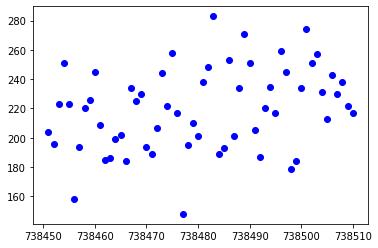

In [87]:
plt.scatter(X['Date'], y, color='blue', label='Original data')

In [88]:
# Fit linear regression model
model = LinearRegression()
model.fit(X_train, y_train)
coef = model.coef_
intercept = model.intercept_
print(coef)


[6.88998554e-01 2.96096815e+01 4.26133154e-03 5.45124876e-01]


In [89]:
y_pred = model.predict(X_test)
# Calculate the R-squared score on the test set
r2 = r2_score(y_test, y_pred)
print("R-squared on test data:", r2)
y_pred

R-squared on test data: 0.4444621792138549


array([211.85356568, 229.42100428, 239.11345703, 219.23981865,
       183.84967042, 197.72019474, 206.31442811, 191.35219053,
       229.06814131, 228.4105278 , 236.10589874, 200.39562491])

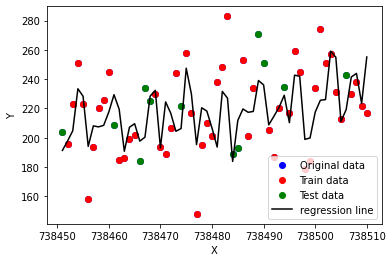

In [90]:
# Plot scatter plot
plt.scatter(df_copy['Date'], df['Order-ID'], color='blue', label='Original data')
plt.scatter(X_train['Date'], y_train, color='red', label='Train data')
plt.scatter(X_test['Date'], y_test, color='green', label='Test data')
plt.plot(df['Date'], model.predict(df[["Date","IsWeekend","Demand_Total Areas","instant"]]), color='k', label='regression line')
plt.legend(loc='lower right')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

Consider that : this form dose not mean that our model face overfit . it is just a pattern

## prediction


In [91]:
xls3 = pd.ExcelFile('Predict.xlsx')
df_predicte = pd.read_excel(xls3)
df_predicte.head()

,Unnamed: 0,Date,IsWeekend,Demand_Predicted,instant
0,2022-12-22,738511,1,11915.630885,71.236229
1,2022-12-23,738512,0,12058.902157,77.951686
2,2022-12-24,738513,0,12120.630970,77.685110
3,2022-12-25,738514,0,12182.359784,77.418533
4,2022-12-26,738515,0,12244.088597,77.151957


In [92]:
# Generate demand predictions for next 14 days using Model 4
df_predicte['Order_predicte'] = model.predict(df_predicte[["Date","IsWeekend","Demand_Predicted","instant"]])
df_predicte

c:\Users\M.M.Nezhad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Demand_Predicted
Feature names seen at fit time, yet now missing:
- Demand_Total Areas

  warnings.warn(message, FutureWarning)


,Unnamed: 0,Date,IsWeekend,Demand_Predicted,instant,Order_predicte
0,2022-12-22,738511,1,11915.630885,71.236229,256.336556
1,2022-12-23,738512,0,12058.902157,77.951686,231.687162
2,2022-12-24,738513,0,12120.630970,77.685110,232.493890
3,2022-12-25,738514,0,12182.359784,77.418533,233.300618
4,2022-12-26,738515,0,12244.088597,77.151957,234.107346
5,2022-12-27,738516,0,12305.817411,76.885381,234.914074
6,2022-12-28,738517,1,12286.003766,69.636771,261.176924
7,2022-12-29,738518,1,12347.732579,69.370195,261.983653
8,2022-12-30,738519,0,12491.003851,76.085652,237.334259
9,2022-12-31,738520,0,12552.732665,75.819075,238.140986


# Kmeans


In [54]:
df_orders
df_Kmeans = df_orders[['Rate_Count_scaled', 'Rate_Score_scaled']]
df_Kmeans

,Rate_Count_scaled,Rate_Score_scaled
0,0.697831,0.029888
1,1.905828,-0.233393
2,0.252780,0.380930
3,-1.082375,-3.480528
4,-1.082375,-3.480528
...,...,...
13176,1.079304,0.029888
13177,1.185269,0.380930
13178,-1.082375,-3.480528
13179,-0.171079,0.029888


## Find best K (Using Elbow method, WCSS)

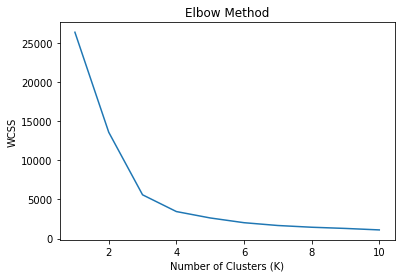

In [55]:
# Store the WCSS values for different K
wcss = []

# Try different values of K
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_Kmeans)
    wcss.append(kmeans.inertia_)  # Inertia is the WCSS value

# Plotting the WCSS values
plt.plot(range(1, 11), wcss)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

As we can see ,optimal number is K = 6 , which after WCSS dose not changes significantly after 6 cluster .

## Make model

In [56]:
kmeans = KMeans(n_clusters=6)

# Fit the K-means model to the data
kmeans.fit(df_Kmeans)

# Get the cluster labels for each data point
cluster_labels = kmeans.labels_

# Add the cluster labels to the original dataframe
df_Kmeans['Cluster_Labels'] = cluster_labels

# Print the resulting dataframe with cluster labels
df_Kmeans

C:\Users\MMEC82~1.NEZ\AppData\Local\Temp/ipykernel_21152/1577640544.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Kmeans['Cluster_Labels'] = cluster_labels


,Rate_Count_scaled,Rate_Score_scaled,Cluster_Labels
0,0.697831,0.029888,0
1,1.905828,-0.233393,4
2,0.252780,0.380930,3
3,-1.082375,-3.480528,2
4,-1.082375,-3.480528,2
...,...,...,...
13176,1.079304,0.029888,0
13177,1.185269,0.380930,0
13178,-1.082375,-3.480528,2
13179,-0.171079,0.029888,3


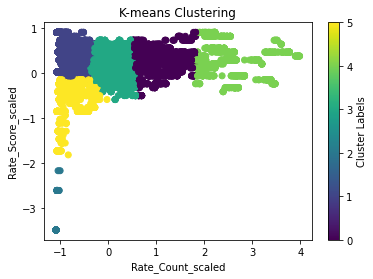

In [57]:
x = df_Kmeans['Rate_Count_scaled']
y = df_Kmeans['Rate_Score_scaled']
cluster_labels = df_Kmeans['Cluster_Labels']

# Create a scatter plot
plt.scatter(x, y, c=cluster_labels, cmap='viridis')
plt.xlabel('Rate_Count_scaled')
plt.ylabel('Rate_Score_scaled')
plt.title('K-means Clustering')
plt.colorbar(label='Cluster Labels')
plt.show()

## Evaluate result 

In [59]:
# Calculate the Silhouette Score
silhouette_avg = silhouette_score(df_Kmeans, cluster_labels)

# Print the Silhouette Score
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.7908863119226377


# Decision tree

In [61]:
df_tree = df_orders.copy()
df_tree


,Date,Order-ID,Accommodation_Code,Areas_Id,Rate_Count,Rate_Score,IsInstant,IsFinalizedOrder,IsHostAccepted,IsGuestPaid,Rate_Count_scaled,Rate_Score_scaled
0,738510,461332,277537,912,84,4.0,False,True,True,True,0.697831,0.029888
1,738510,461326,256370,912,141,3.7,False,False,True,False,1.905828,-0.233393
2,738510,461323,253572,139,63,4.4,True,False,True,False,0.252780,0.380930
3,738510,461319,259745,912,0,0.0,False,False,False,False,-1.082375,-3.480528
4,738510,461315,311907,912,0,0.0,True,True,True,True,-1.082375,-3.480528
...,...,...,...,...,...,...,...,...,...,...,...,...
13176,738451,504071,24772,139,102,4.0,False,True,True,True,1.079304,0.029888
13177,738451,400644,253214,912,107,4.4,False,False,True,False,1.185269,0.380930
13178,738451,400640,304427,800,0,0.0,True,True,True,True,-1.082375,-3.480528
13179,738451,400631,1963,912,43,4.0,False,False,True,False,-0.171079,0.029888


In [62]:
# Select the features and target variable
features = ['IsInstant', 'Rate_Score_scaled', 'Areas_Id']

target = 'IsFinalizedOrder'

# Filter the dataframe for the relevant data points
filtered_df = df_tree
filtered_df

# Split the data into training and testing sets
X = filtered_df[features]
y = filtered_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a decision tree classifier
clf = DecisionTreeClassifier()

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = clf.predict(X_test)


# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.5915813424345847


In [63]:
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

[[ 370  742]
 [ 335 1190]]


In [64]:
# Generate the textual representation of the decision tree rules
tree_rules = export_text(clf, feature_names= features )

# Print the decision tree rules
print(tree_rules)

|--- Rate_Score_scaled <= -0.80
|   |--- IsInstant <= 0.50
|   |   |--- Areas_Id <= 46.00
|   |   |   |--- Rate_Score_scaled <= -3.04
|   |   |   |   |--- class: False
|   |   |   |--- Rate_Score_scaled >  -3.04
|   |   |   |   |--- Rate_Score_scaled <= -0.94
|   |   |   |   |   |--- class: True
|   |   |   |   |--- Rate_Score_scaled >  -0.94
|   |   |   |   |   |--- class: True
|   |   |--- Areas_Id >  46.00
|   |   |   |--- Rate_Score_scaled <= -1.20
|   |   |   |   |--- Rate_Score_scaled <= -1.33
|   |   |   |   |   |--- Rate_Score_scaled <= -1.51
|   |   |   |   |   |   |--- Areas_Id <= 952.00
|   |   |   |   |   |   |   |--- Areas_Id <= 108.50
|   |   |   |   |   |   |   |   |--- Rate_Score_scaled <= -3.04
|   |   |   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |   |   |   |--- Rate_Score_scaled >  -3.04
|   |   |   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |   |   |--- Areas_Id >  108.50
|   |   |   |   |   |   |   |   |--- Rate_Score_scaled 

# neural network

In [45]:
df_ANN = df_orders.copy()
df_ANN['IsInstant_encoded'] = df_ANN['IsInstant'].astype(int)
df_ANN['Areas_Id_encoded'] = df_ANN['Areas_Id'].astype(int)
df_ANN

,Date,Order-ID,Accommodation_Code,Areas_Id,Rate_Count,Rate_Score,IsInstant,IsFinalizedOrder,IsHostAccepted,IsGuestPaid,Rate_Count_scaled,Rate_Score_scaled,IsInstant_encoded,Areas_Id_encoded
0,738510,461332,277537,912,84,4.0,False,True,True,True,0.697831,0.029888,0,912
1,738510,461326,256370,912,141,3.7,False,False,True,False,1.905828,-0.233393,0,912
2,738510,461323,253572,139,63,4.4,True,False,True,False,0.252780,0.380930,1,139
3,738510,461319,259745,912,0,0.0,False,False,False,False,-1.082375,-3.480528,0,912
4,738510,461315,311907,912,0,0.0,True,True,True,True,-1.082375,-3.480528,1,912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13176,738451,504071,24772,139,102,4.0,False,True,True,True,1.079304,0.029888,0,139
13177,738451,400644,253214,912,107,4.4,False,False,True,False,1.185269,0.380930,0,912
13178,738451,400640,304427,800,0,0.0,True,True,True,True,-1.082375,-3.480528,1,800
13179,738451,400631,1963,912,43,4.0,False,False,True,False,-0.171079,0.029888,0,912


In [52]:
# Assuming your DataFrame is named 'df'
# Extract features and target variable
features = df_ANN[['Areas_Id', 'Rate_Count_scaled', 'Rate_Score_scaled', 'IsInstant_encoded']]
# features = df_ANN[['Rate_Count_scaled', 'Rate_Score_scaled', 'IsInstant_encoded']]

target = df_ANN['IsFinalizedOrder']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the ANN model
model = keras.Sequential([
    keras.layers.Dense(16, activation='relu', input_shape=(4,)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train, epochs=100, batch_size=100)


Epoch 1/100
106/106 [==============================] - 1s 2ms/step - loss: 0.6825 - accuracy: 0.5721
Epoch 2/100
106/106 [==============================] - 0s 2ms/step - loss: 0.6804 - accuracy: 0.5744
Epoch 3/100
106/106 [==============================] - 0s 2ms/step - loss: 0.6791 - accuracy: 0.5822
Epoch 4/100
106/106 [==============================] - 0s 2ms/step - loss: 0.6781 - accuracy: 0.5829
Epoch 5/100
106/106 [==============================] - 0s 2ms/step - loss: 0.6780 - accuracy: 0.5808
Epoch 6/100
106/106 [==============================] - 0s 2ms/step - loss: 0.6773 - accuracy: 0.5795
Epoch 7/100
106/106 [==============================] - 0s 2ms/step - loss: 0.6772 - accuracy: 0.5819
Epoch 8/100
106/106 [==============================] - 0s 2ms/step - loss: 0.6767 - accuracy: 0.5818
Epoch 9/100
106/106 [==============================] - 0s 2ms/step - loss: 0.6767 - accuracy: 0.5839
Epoch 10/100
106/106 [==============================] - 0s 2ms/step - loss: 0.6767 - accura

In [53]:
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print('Accuracy:', accuracy)

# Make predictions
predictions = model.predict(X_test_scaled)

83/83 [==============================] - 0s 2ms/step - loss: 0.6716 - accuracy: 0.5961
Accuracy: 0.5961319804191589
83/83 [==============================] - 0s 1ms/step


In [48]:
# Convert predicted probabilities to binary predictions
binary_predictions = np.where(predictions > 0.5, 1, 0)

# Calculate confusion matrix
confusion = confusion_matrix(y_test, binary_predictions)
print(confusion)

[[ 316  796]
 [ 273 1252]]


In [50]:
plot_model(model, to_file='ann_model.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
